In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#some code for checking gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import numpy as np
import os
import tqdm
import pandas as pd
import keras
import time, warnings
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import KFold, train_test_split, LeaveOneGroupOut, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
    Activation,
    GlobalAveragePooling2D,
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

warnings.filterwarnings("ignore")


In [5]:
#change dir here for loading files and metadata
root_folder = r"/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/both"
metadata = pd.read_csv('/content/drive/MyDrive/UrbanSound8kv2/Data_extracted/processed_data.csv')

In [6]:
def normalize(clip):
    normalized_clip = (clip - np.min(clip)) / (np.max(clip) - np.min(clip))
    return normalized_clip

def conv_array(root_folder,metadata):
  # process all folds and put them into dictionary
    folds = {}
    for fold in range(1, 11):
        fold_path = os.path.join(root_folder, f"fold{fold}")
        image_data = []
        all_labels = []
        if not os.path.exists(fold_path):
            print(f"folder{fold} not found error")
            continue  # Skip if the folder doesn't exist
        for filename in tqdm.tqdm(os.listdir(fold_path)):
            if filename.endswith(".png"):
                image_path = os.path.join(fold_path, filename)
                image = Image.open(image_path)
                new_filename = filename.replace('.png', '.wav')
                row_num = metadata[metadata['slice_file_name'] == new_filename].index
                if not row_num.empty:
                    image_array = np.array(image)
                    if not image_array.shape == (76, 33):
                      print("wrong image shape error")
                      continue
                    image_array = normalize(image_array)
                    label = metadata.iloc[row_num]['labelID'].values[0]
                    all_labels.append(label)
                    image_data.append(image_array)
                else:
                    print(f'{new_filename} not found')
                    continue
        image_data = np.array(image_data)
        all_labels = np.array(all_labels)
        all_labels = to_categorical(all_labels, num_classes=10)
        #converting numpy arrays to tf.tensor for GPU optimization
        image_data_tensor = tensorflow.convert_to_tensor(image_data)
        all_labels_tensor = tensorflow.convert_to_tensor(all_labels)
        #print(image_data_tensor)
        folds[f"fold{fold}"] = [image_data_tensor, all_labels_tensor]
    return folds


data = conv_array(root_folder,metadata)
input_shape = data['fold1'][0].shape
print(f"input shape is {input_shape}")

100%|██████████| 837/837 [00:09<00:00, 85.97it/s] 

input shape is (873, 76, 33)


In [7]:
print(data['fold1'][0][0])

tf.Tensor(
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [0.27843137 0.2745098  0.27843137 ... 0.27058824 0.27058824 0.27843137]
 [0.27843137 0.2745098  0.27843137 ... 0.2627451  0.27058824 0.2745098 ]
 [1.         0.99607843 1.         ... 0.98823529 0.99607843 1.        ]], shape=(76, 33), dtype=float64)


Trial 20 Complete [00h 00m 21s]
val_loss: 1.652925431728363

Best val_loss So Far: 1.267722249031067
Total elapsed time: 00h 08m 00s


  0%|          | 0/10 [00:00<?, ?it/s]

Training using fold1 as validation
Epoch 1/25
62/62 [==============================] - 2s 12ms/step - loss: 2.1845 - accuracy: 0.1867 - val_loss: 1.8108 - val_accuracy: 0.3654 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 0s 7ms/step - loss: 1.8041 - accuracy: 0.3124 - val_loss: 1.6795 - val_accuracy: 0.2944 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 0s 6ms/step - loss: 1.6724 - accuracy: 0.3556 - val_loss: 1.6031 - val_accuracy: 0.4215 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 0s 6ms/step - loss: 1.6062 - accuracy: 0.3845 - val_loss: 1.5731 - val_accuracy: 0.3826 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 0s 5ms/step - loss: 1.5349 - accuracy: 0.4204 - val_loss: 1.5157 - val_accuracy: 0.4525 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 0s 6ms/step - loss: 1.4956 - accuracy: 0.4414 - val_loss: 1.4598 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 7/25
62/62 [============================

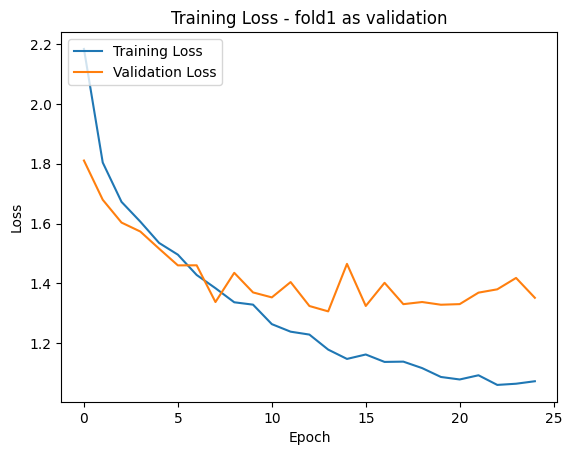

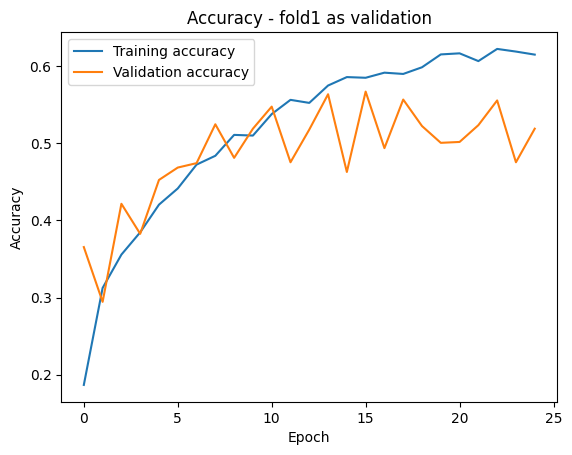

 10%|█         | 1/10 [00:32<04:49, 32.12s/it]

Training using fold2 as validation
Epoch 1/25
62/62 [==============================] - 3s 15ms/step - loss: 2.1843 - accuracy: 0.1906 - val_loss: 1.8304 - val_accuracy: 0.3041 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 1s 9ms/step - loss: 1.8301 - accuracy: 0.2882 - val_loss: 1.8164 - val_accuracy: 0.3277 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 0s 8ms/step - loss: 1.6898 - accuracy: 0.3525 - val_loss: 1.6240 - val_accuracy: 0.3491 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 1s 8ms/step - loss: 1.5795 - accuracy: 0.3969 - val_loss: 1.5884 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 0s 7ms/step - loss: 1.5027 - accuracy: 0.4402 - val_loss: 1.5428 - val_accuracy: 0.4077 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 1s 8ms/step - loss: 1.4389 - accuracy: 0.4671 - val_loss: 1.5641 - val_accuracy: 0.4381 - lr: 0.0010
Epoch 7/25
62/62 [============================

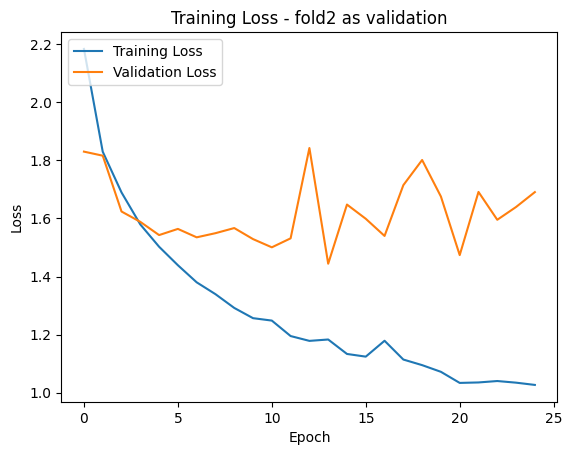

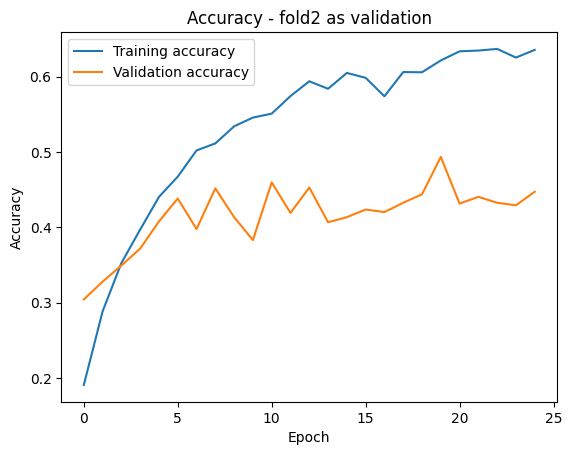

 20%|██        | 2/10 [01:01<04:01, 30.23s/it]

Training using fold3 as validation
Epoch 1/25
61/61 [==============================] - 2s 12ms/step - loss: 2.1694 - accuracy: 0.1973 - val_loss: 1.9520 - val_accuracy: 0.3092 - lr: 0.0010
Epoch 2/25
61/61 [==============================] - 0s 7ms/step - loss: 1.8262 - accuracy: 0.2983 - val_loss: 1.6472 - val_accuracy: 0.3978 - lr: 0.0010
Epoch 3/25
61/61 [==============================] - 0s 7ms/step - loss: 1.6669 - accuracy: 0.3558 - val_loss: 1.6103 - val_accuracy: 0.4389 - lr: 0.0010
Epoch 4/25
61/61 [==============================] - 0s 8ms/step - loss: 1.5833 - accuracy: 0.3886 - val_loss: 1.5221 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 5/25
61/61 [==============================] - 0s 7ms/step - loss: 1.5070 - accuracy: 0.4331 - val_loss: 1.5293 - val_accuracy: 0.4119 - lr: 0.0010
Epoch 6/25
61/61 [==============================] - 0s 8ms/step - loss: 1.4447 - accuracy: 0.4613 - val_loss: 1.4328 - val_accuracy: 0.4432 - lr: 0.0010
Epoch 7/25
61/61 [============================

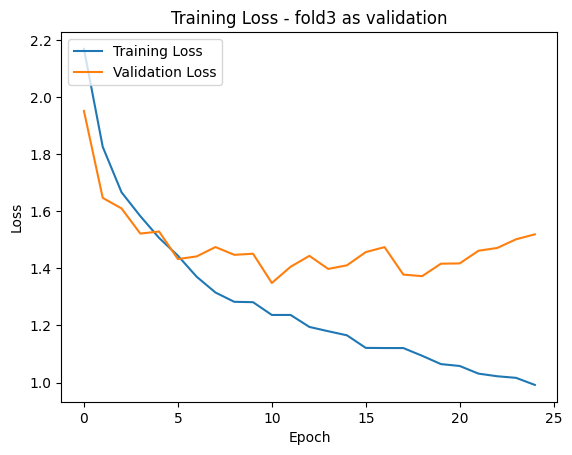

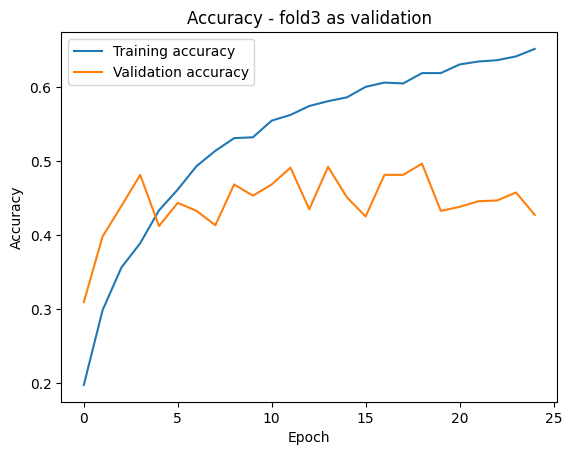

 30%|███       | 3/10 [01:19<02:55, 25.03s/it]

Training using fold4 as validation
Epoch 1/25
61/61 [==============================] - 2s 9ms/step - loss: 2.1703 - accuracy: 0.2009 - val_loss: 1.9294 - val_accuracy: 0.2212 - lr: 0.0010
Epoch 2/25
61/61 [==============================] - 0s 7ms/step - loss: 1.8384 - accuracy: 0.2971 - val_loss: 1.6789 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 3/25
61/61 [==============================] - 0s 6ms/step - loss: 1.6506 - accuracy: 0.3626 - val_loss: 1.6600 - val_accuracy: 0.3192 - lr: 0.0010
Epoch 4/25
61/61 [==============================] - 0s 7ms/step - loss: 1.5799 - accuracy: 0.3940 - val_loss: 1.5378 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 5/25
61/61 [==============================] - 0s 6ms/step - loss: 1.5098 - accuracy: 0.4264 - val_loss: 1.5394 - val_accuracy: 0.4414 - lr: 0.0010
Epoch 6/25
61/61 [==============================] - 0s 6ms/step - loss: 1.4259 - accuracy: 0.4689 - val_loss: 1.5429 - val_accuracy: 0.4121 - lr: 0.0010
Epoch 7/25
61/61 [=============================

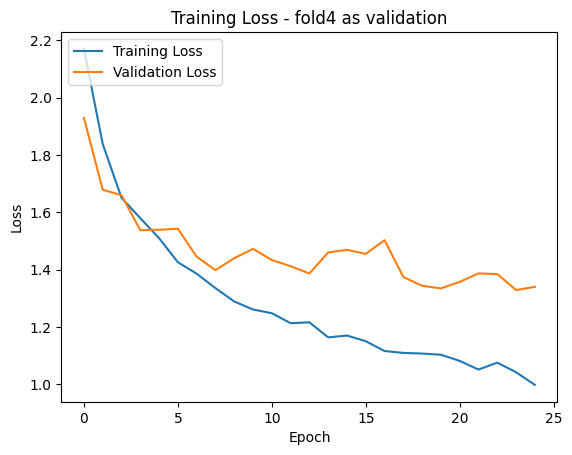

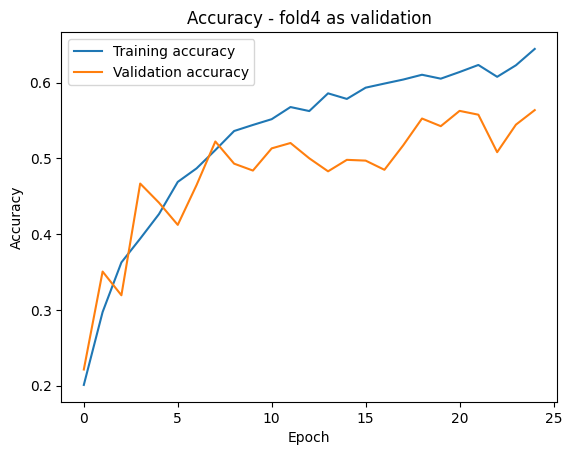

 40%|████      | 4/10 [01:40<02:19, 23.24s/it]

Training using fold5 as validation
Epoch 1/25
61/61 [==============================] - 2s 9ms/step - loss: 2.1625 - accuracy: 0.1943 - val_loss: 2.0623 - val_accuracy: 0.2468 - lr: 0.0010
Epoch 2/25
61/61 [==============================] - 0s 6ms/step - loss: 1.8033 - accuracy: 0.3035 - val_loss: 1.8845 - val_accuracy: 0.2660 - lr: 0.0010
Epoch 3/25
61/61 [==============================] - 0s 6ms/step - loss: 1.6634 - accuracy: 0.3621 - val_loss: 1.7848 - val_accuracy: 0.2831 - lr: 0.0010
Epoch 4/25
61/61 [==============================] - 0s 7ms/step - loss: 1.5991 - accuracy: 0.3890 - val_loss: 1.7277 - val_accuracy: 0.2927 - lr: 0.0010
Epoch 5/25
61/61 [==============================] - 0s 7ms/step - loss: 1.5061 - accuracy: 0.4366 - val_loss: 1.5615 - val_accuracy: 0.3889 - lr: 0.0010
Epoch 6/25
61/61 [==============================] - 0s 6ms/step - loss: 1.4464 - accuracy: 0.4551 - val_loss: 1.6136 - val_accuracy: 0.3718 - lr: 0.0010
Epoch 7/25
61/61 [=============================

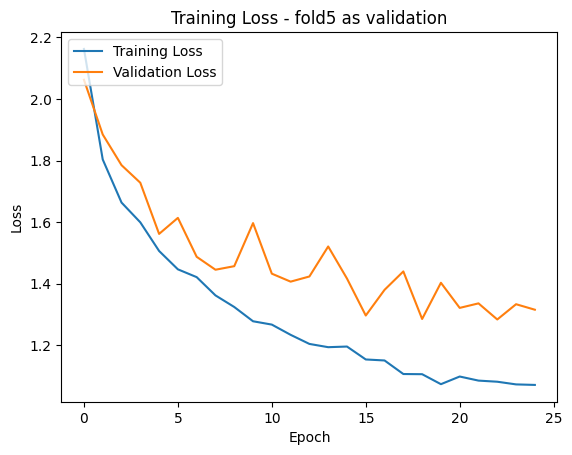

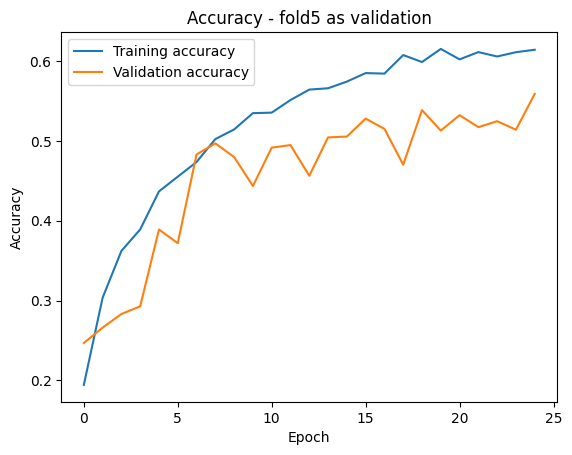

 50%|█████     | 5/10 [01:59<01:49, 21.89s/it]

Training using fold6 as validation
Epoch 1/25
62/62 [==============================] - 2s 9ms/step - loss: 2.2214 - accuracy: 0.1723 - val_loss: 1.9689 - val_accuracy: 0.2491 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 0s 7ms/step - loss: 1.8685 - accuracy: 0.2922 - val_loss: 1.6633 - val_accuracy: 0.3305 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 0s 7ms/step - loss: 1.7094 - accuracy: 0.3434 - val_loss: 1.6581 - val_accuracy: 0.3354 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 0s 7ms/step - loss: 1.5969 - accuracy: 0.3879 - val_loss: 1.6348 - val_accuracy: 0.4143 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 0s 7ms/step - loss: 1.5248 - accuracy: 0.4275 - val_loss: 1.6481 - val_accuracy: 0.3487 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 0s 7ms/step - loss: 1.4675 - accuracy: 0.4532 - val_loss: 1.4713 - val_accuracy: 0.4034 - lr: 0.0010
Epoch 7/25
62/62 [=============================

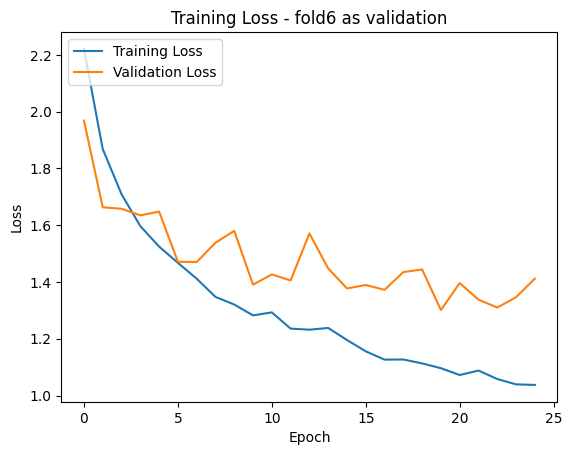

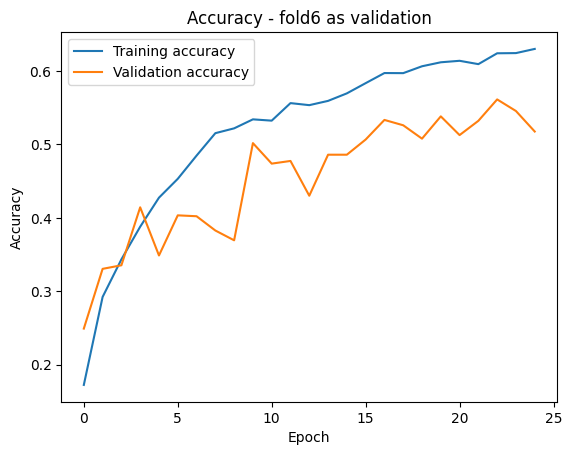

 60%|██████    | 6/10 [02:19<01:24, 21.00s/it]

Training using fold7 as validation
Epoch 1/25
62/62 [==============================] - 2s 9ms/step - loss: 2.2205 - accuracy: 0.1806 - val_loss: 1.8903 - val_accuracy: 0.3210 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 0s 7ms/step - loss: 1.8406 - accuracy: 0.2922 - val_loss: 1.7154 - val_accuracy: 0.3711 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 0s 7ms/step - loss: 1.6760 - accuracy: 0.3555 - val_loss: 1.6314 - val_accuracy: 0.3819 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 0s 8ms/step - loss: 1.6015 - accuracy: 0.3883 - val_loss: 1.6020 - val_accuracy: 0.3150 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 0s 8ms/step - loss: 1.5264 - accuracy: 0.4294 - val_loss: 1.5378 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 0s 7ms/step - loss: 1.4652 - accuracy: 0.4546 - val_loss: 1.5048 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 7/25
62/62 [=============================

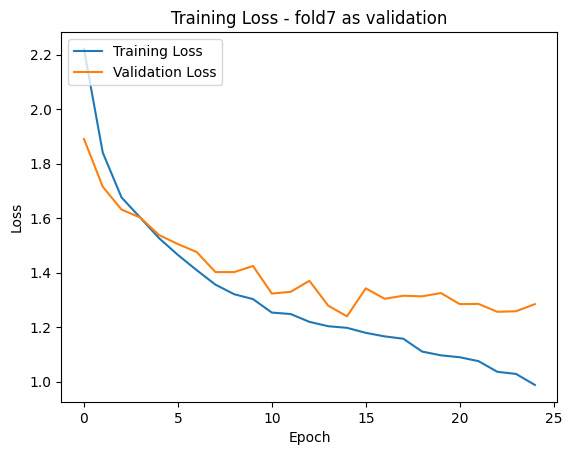

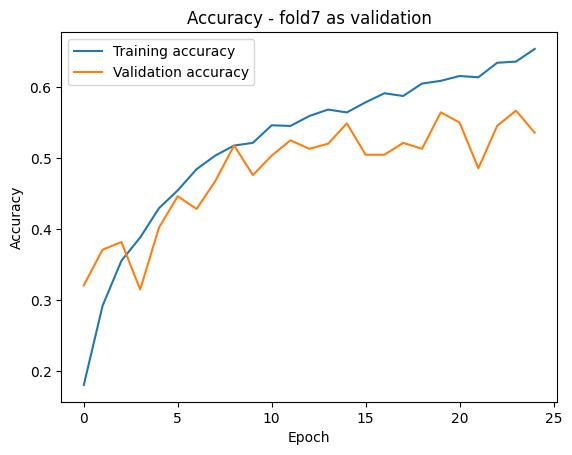

 70%|███████   | 7/10 [02:47<01:09, 23.30s/it]

Training using fold8 as validation
Epoch 1/25
62/62 [==============================] - 2s 9ms/step - loss: 2.1680 - accuracy: 0.1951 - val_loss: 1.8480 - val_accuracy: 0.2419 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 0s 7ms/step - loss: 1.8269 - accuracy: 0.2994 - val_loss: 1.5904 - val_accuracy: 0.3834 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 0s 7ms/step - loss: 1.6821 - accuracy: 0.3473 - val_loss: 1.5270 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 0s 6ms/step - loss: 1.5969 - accuracy: 0.3837 - val_loss: 1.4621 - val_accuracy: 0.4007 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 0s 6ms/step - loss: 1.5031 - accuracy: 0.4311 - val_loss: 1.4635 - val_accuracy: 0.4876 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 0s 6ms/step - loss: 1.4413 - accuracy: 0.4605 - val_loss: 1.3954 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 7/25
62/62 [=============================

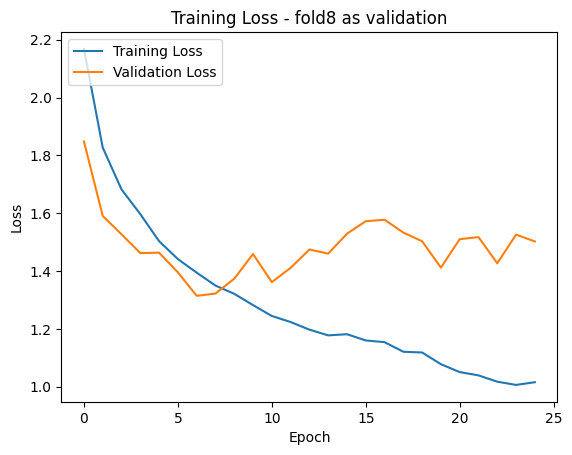

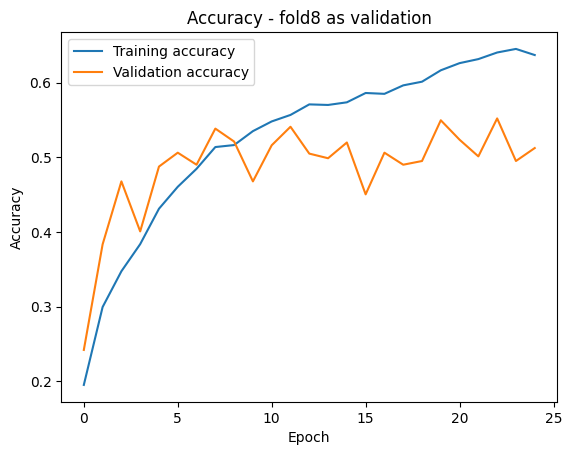

 80%|████████  | 8/10 [03:06<00:44, 22.17s/it]

Training using fold9 as validation
Epoch 1/25
62/62 [==============================] - 2s 9ms/step - loss: 2.1659 - accuracy: 0.1945 - val_loss: 1.8759 - val_accuracy: 0.2831 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 0s 6ms/step - loss: 1.8166 - accuracy: 0.3056 - val_loss: 1.7517 - val_accuracy: 0.2782 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 0s 6ms/step - loss: 1.6833 - accuracy: 0.3522 - val_loss: 1.6734 - val_accuracy: 0.3137 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 0s 7ms/step - loss: 1.5881 - accuracy: 0.3975 - val_loss: 1.5810 - val_accuracy: 0.3676 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 0s 7ms/step - loss: 1.4928 - accuracy: 0.4330 - val_loss: 1.5005 - val_accuracy: 0.4314 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 0s 6ms/step - loss: 1.4724 - accuracy: 0.4548 - val_loss: 1.5289 - val_accuracy: 0.3811 - lr: 0.0010
Epoch 7/25
62/62 [=============================

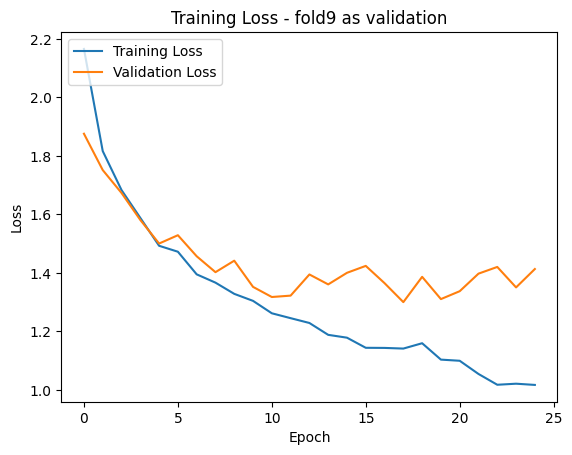

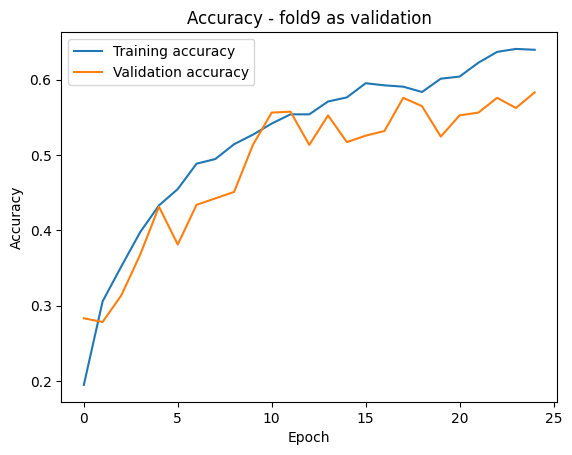

 90%|█████████ | 9/10 [03:34<00:23, 23.89s/it]

Training using fold10 as validation
Epoch 1/25
62/62 [==============================] - 2s 10ms/step - loss: 2.2249 - accuracy: 0.1804 - val_loss: 1.8941 - val_accuracy: 0.2616 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 0s 7ms/step - loss: 1.8429 - accuracy: 0.2964 - val_loss: 1.7588 - val_accuracy: 0.2987 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 0s 7ms/step - loss: 1.6878 - accuracy: 0.3476 - val_loss: 1.6628 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 0s 7ms/step - loss: 1.5923 - accuracy: 0.3947 - val_loss: 1.6380 - val_accuracy: 0.4289 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 0s 7ms/step - loss: 1.4870 - accuracy: 0.4438 - val_loss: 1.5934 - val_accuracy: 0.3763 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 0s 6ms/step - loss: 1.4132 - accuracy: 0.4732 - val_loss: 1.6313 - val_accuracy: 0.3871 - lr: 0.0010
Epoch 7/25
62/62 [===========================

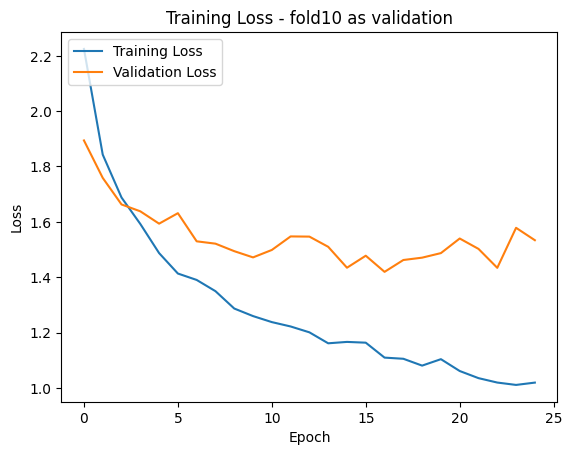

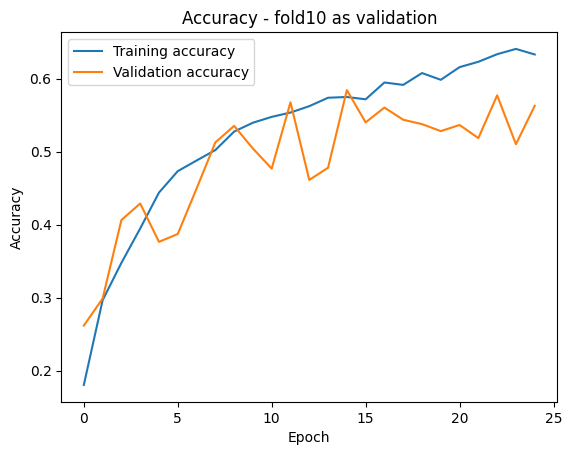

100%|██████████| 10/10 [04:03<00:00, 24.36s/it]


List of scores[0.5189003348350525, 0.4470720589160919, 0.42702701687812805, 0.5636363625526428, 0.5587607026100159, 0.5176184773445129, 0.535799503326416, 0.5124069452285767, 0.5833333134651184, 0.5627239942550659]
Average accuracy: 0.5227278709411621 has standard deviation 0.048420222599223954
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2508)              0         
                                                                 
 dense (Dense)               (None, 1024)              2569216   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)        

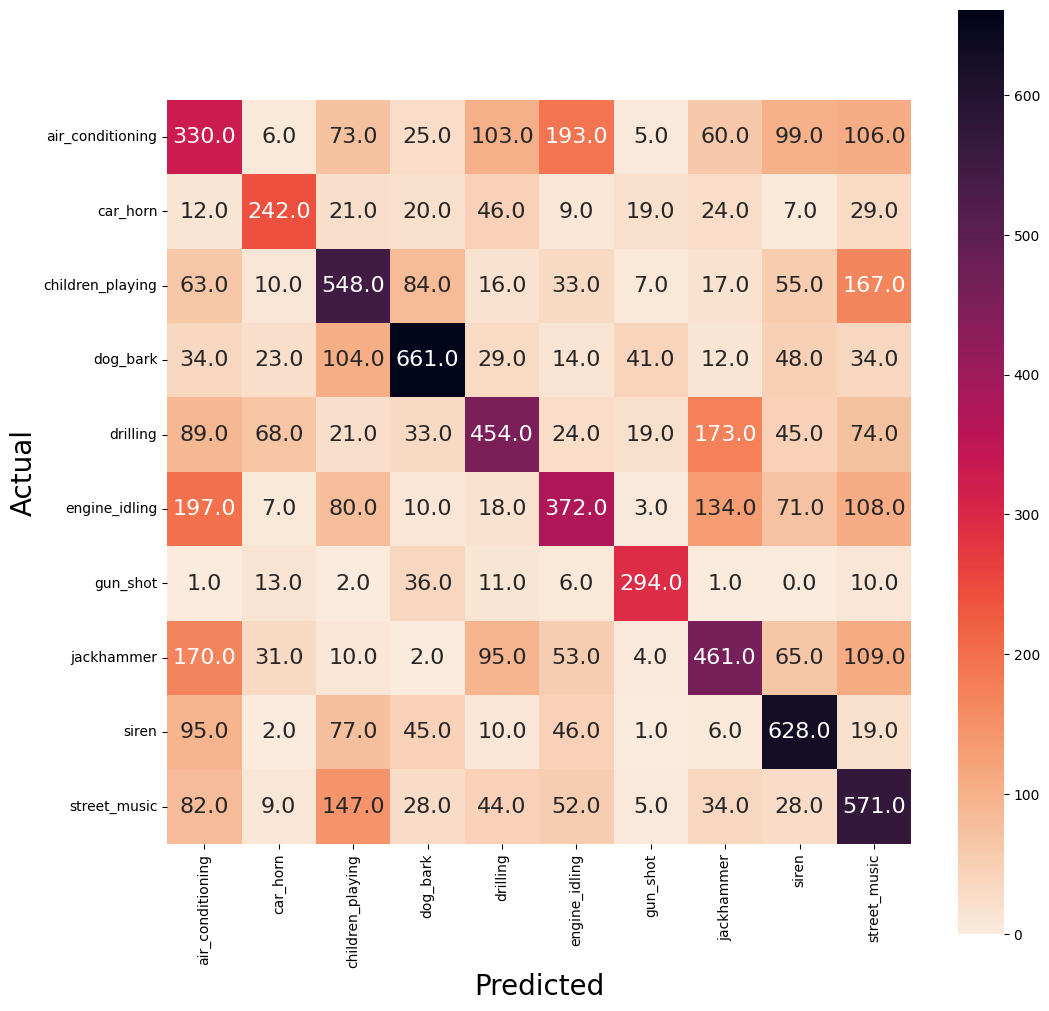

In [8]:
tensorflow.keras.backend.clear_session()

def build_model(hp):
    model = Sequential()

    input_shape = data['fold1'][0].shape[1:]

    # Flatten the input for MLP
    model.add(Flatten(input_shape=input_shape))

    # Add dense layers
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Dense(hp.Choice(f'dense_{i}_units',
                                  values=[128, 256, 512, 1024])))
        model.add(Activation('relu'))

        # Adding dropout
        model.add(Dropout(rate=hp.Float('rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(10))
    model.add(Activation("softmax"))

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=loss,
                  metrics=[metric])

    return model


#get optimal hyperparameters using
def tuner(num_epoch, batch_size,max_trials,trial_retrys):
  # creating data to tune on. We tune on fold1 as val
  fold_name = "fold1"
  print(f"Training using {fold_name} as validation")
  X_val, y_val = data[fold_name][0], data[fold_name][1]
  X_train = []
  y_train = []

  for other_fold_name, other_fold_data in data.items():
    if other_fold_name == fold_name:
        continue

    X = other_fold_data[0]
    y = other_fold_data[1]
    X_train.extend(X)
    y_train.extend(y)
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  # buiilding the tuning model
  EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)
  tuner = RandomSearch(build_model, objective=objective, max_trials=max_trials, executions_per_trial=trial_retrys, metrics=[metric])
  tuner.search(x=X_train, y=y_train, epochs=num_epoch, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[EarlyStoppingCallback]) # batch size and epoch number is fixxed. Earlystopping enabled
  best_hyperparameters = tuner.oracle.get_best_trials(1)[0].hyperparameters.values
  return best_hyperparameters
# return best hyperparameters for use in 10-fold cross validation



def model_k_cross(hyperparameters, data):
    hp = kt.HyperParameters()
    list_scores = []
    Ytrue_list = []  # Use lists to store predictions
    Ypred_list = []
    # get model keys
    for key, value in hyperparameters.items():
        hp.Fixed(key, value)
    # 10 fold val main loop
    for fold_name, fold_data in tqdm.tqdm(data.items()):
        tensorflow.keras.backend.clear_session()
        print(f"Training using {fold_name} as validation")
        X_val, y_val = fold_data[0], fold_data[1]
        X_train = []
        y_train = []
        # prepare data for every loop
        for other_fold_name, other_fold_data in data.items():
            if other_fold_name == fold_name:
                continue

            X = other_fold_data[0]
            y = other_fold_data[1]
            X_train.extend(X)
            y_train.extend(y)

        X_train = np.array(X_train)
        y_train = np.array(y_train)
        # build model
        cmodel = build_model(hp)
        cmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
        # normally put this, but we wanted to plot for 25 iterations fixxed
        EarlyStoppingCallback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop)

        history = cmodel.fit(X_train, y_train, epochs=num_epoch, batch_size=batch_size,
                             callbacks=[anne], validation_data=(X_val, y_val)) # we dont use the EarlyStoppingCallback here for the sake of plotting

        # Evaluation
        scores = cmodel.evaluate(X_val, y_val)
        print("Validation accuracy:", scores[1])
        list_scores.append(scores[1])
        # for the confusion matrix
        Ypred_it = cmodel.predict(X_val)
        Ypred_it = np.argmax(Ypred_it, axis=1)
        Ytrue_it = np.argmax(y_val, axis=1)
        Ytrue_list.extend(Ytrue_it.tolist())  # Append predictions to lists
        Ypred_list.extend(Ypred_it.tolist())


        # Plot training history - loss
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f"Training Loss - {fold_name} as validation")
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
        plt.show()
        # accuracy
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f"Accuracy - {fold_name} as validation")
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Training accuracy', 'Validation accuracy'], loc='upper left')
        plt.show()

       # Convert lists to NumPy arrays after the loop
    Ytrue = np.array(Ytrue_list)
    Ypred = np.array(Ypred_list)
    # print of accuracy mean and std
    average_acc = sum(list_scores) / len(list_scores)
    accuracy_std = np.std(list_scores)
    print(f'List of scores{list_scores}')
    print(f'Average accuracy: {average_acc} has standard deviation {accuracy_std}')


    label = ['air_conditioning', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
    # matrix
    cm = confusion_matrix(Ytrue, Ypred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    cmodel.summary()



#creating custom hyperparameters to inspect model performance,inspired by the network we found on kaggle
custom_hyperparameters = {
        'input_units': 224,
        'n_layers': 4,
        'conv_0_units': 64,
        'rate': 0.2,
        'n_connections': 3,
        'n_nodes': 1012,
        'conv_1_units': 128,
    }


metric = 'accuracy' #evaluation metric
loss= 'categorical_crossentropy' #loss function

#training parameters
num_epoch = 25
batch_size = 128
early_stop = 5 # early stoppping after 6 epochs with no improvement of test data

#objective to specify the objective to select the best models, and we use max_trials to specify the number of different models to try.
objective='val_loss'
max_trials = 20 # how many model variations to test?
trial_retrys = 2 # how many trials per variation? (same model could perform differently)



best_hyperparameters_overall = tuner(num_epoch,batch_size,max_trials,trial_retrys)
model_k_cross(best_hyperparameters_overall, data)
print(best_hyperparameters_overall)
#model_k_cross(custom_hyperparameters, data)

